# Modeling Vaccinations Rollout
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/epydemix/blob/main/tutorials/09_Vaccinations.ipynb)

If you are running this tutorial on Google Colab, you can install the needed packages by running the following cell:

In [ ]:
import sys,os,subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable,"-m","pip","install","-q","-r","https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

In this tutorial, we will simulate the rollout of a vaccination campaign on a population. We consider the following SIR-like model with the addition of a vaccinated compartment: 

$$S + I \rightarrow_{\beta} 2I$$
$$S \rightarrow_{r(t)} S_V$$
$$S_V + I \rightarrow_{\beta (1 - VE)} 2I$$
$$I \rightarrow_{\mu} R$$

In other words, susceptible individuals get vaccinated at a rate $r(t)$ which depends on the number of vaccine doses administerd on day $t$. Vaccinated individuals have a reduced transmission rate $\beta (1 - VE)$, where $VE$ is the vaccine effectiveness against infection (i.e., a VE of 100% means that $S_V$ are completely immune). 

To mimic a real vaccination campaign, we assume that vaccinations are organized such that, for each day, the number of doses administered to each age group is reported. We generate this data using a logistic function, which captures the initial ramp-up period before daily administrations reach equilibrium. Of course, alternative functional forms (e.g., constant daily doses) can also be considered.

,0-4,5-19,20-49,50-64,65+
2021-01-01,22,160,83,95,931
2021-01-02,13,208,81,294,1088
2021-01-03,89,109,218,214,1069
2021-01-04,71,135,205,315,1205
2021-01-05,18,168,187,353,1298


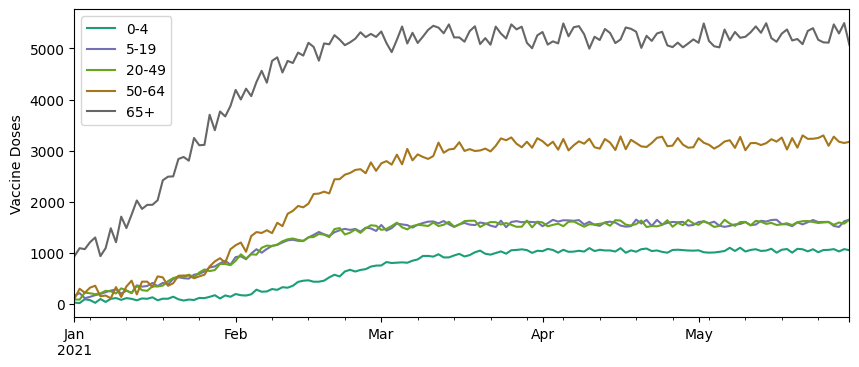

In [1]:
from epydemix.utils import compute_simulation_dates
import pandas as pd
import numpy as np

# Simulation dates
start_date, end_date = "2021-01-01", "2021-05-30"
dates = compute_simulation_dates(start_date, end_date)

def logistic(k, t, L, tm):
    """Logistic Function"""
    return L / (1 + np.exp(-k * (t - tm)))

# We consider standard epydemix age groups for simplicity
age_groups = ["0-4", "5-19", "20-49", "50-64", "65+"]

# Max daily doses at regime and t1/2 for each group
maxs = [1000, 1500, 1500, 3000, 5000]
tms = [50, 30, 30, 40, 20]
doses_dict = {}

# Compute daily doses per each age group/day according to logistic + some random noise
for grp, max_, tm in zip(age_groups, maxs, tms): 
    doses_dict[grp] = np.array([logistic(0.1, t, max_, tm) + np.random.random() * max_/10 for t in range(len(dates))]).astype(int)

# Plot
df_doses = pd.DataFrame(data=doses_dict, index=dates)
df_doses.plot(cmap="Dark2", figsize=(10,4), ylabel="Vaccine Doses")
df_doses.head()

We are now ready to build the model. As a final step, we need to define a specific transition for vaccination. In this case, vaccination represents a particular type of transition whose rate depends on the number of daily doses provided as input.

To make things more realistic, we assume that individuals in both $S$ and $R$ compartments can receive the vaccine, but only doses administered to those in the susceptible ($S$) compartment are effective. This distinction becomes especially relevant as the number of recovered individuals ($R$) increases. If we ignore it, we risk overestimating the impact of vaccination, since the number of effective doses (those given to $S$) is smaller than the total number of doses administered. Of course, this assumption can be modified or relaxed depending on the modeling needs.

To define a new transition we simply needs to define the function that computes the transition rate:

In [2]:
def compute_vaccination_rate(params, data):
    """ 
    Compute the vaccination rate.

    Args:
        params: list of parameters for this transition, first element is the total number of doses for a given day
        data: dictionary containing the population, the compartments, and other information about the system

    Returns:
        np.array of vaccination rates for each age group
    """
    # Get total doses for today for each age group
    total_doses = params[0][data["t"]]

    # Assume the vaccinations are given across the whole population except the infectious and the vaccinated
    # but only effective for the susceptible population 
    # so we compute effective doses as the total doses times the fraction of susceptible population w.r.t eligible population
    fraction_S = data["pop"][data["comp_indices"]["S"]] / (data["pop"][data["comp_indices"]["S"]] + + data["pop"][data["comp_indices"]["R"]])
    effective_doses = total_doses * fraction_S

    # Compute the rate of vaccination for each age group
    # (edge case: more doses than S individuals -> rate_vax ~ 1)
    rate_vax = []
    for i in range(len(effective_doses)):
        if effective_doses[i] < data["pop"][data["comp_indices"]["S"]][i]: 
            rate_vax.append(effective_doses[i] / data["pop"][data["comp_indices"]["S"]][i])
        else: 
            rate_vax.append(0.999)

    return np.array(rate_vax)

Finally, we define the model:

In [4]:
from epydemix.model import EpiModel
from epydemix.population import load_epydemix_population

model = EpiModel(compartments=["S", "SV", "I", "R"])
model.register_transition_kind("vaccination", compute_vaccination_rate)

# S + I -> 2I
model.add_transition("S", "I", params=("beta", "I"), kind="mediated")

# SV + I -> 2I
model.add_transition("SV", "I", params=("(1 - VE) * beta", "I"), kind="mediated")

# S -> SV
model.add_transition("S", "SV", params=(df_doses[["0-4", "5-19", "20-49", "50-64", "65+"]].values,), kind="vaccination")

# I -> R
model.add_transition("I", "R", params=("mu"), kind="spontaneous")

We define the parameters assuming a VE=70%, set the population, and run the model:

In [5]:
model.add_parameter(parameters_dict={"beta": 0.02, 
                                     "mu": 0.1, 
                                     "VE": 0.7})

population = load_epydemix_population("United_States_Utah")
model.set_population(population)

# simulate 
results = model.run_simulations(start_date=start_date, 
                                end_date=end_date, 
                                Nsim=10, 
                                initial_conditions_dict={"S": model.population.Nk - np.ones(5)*10, 
                                                         "I": np.ones(5)*10,
                                                         "SV": np.zeros(5), 
                                                         "R": np.zeros(5)})

We retrieve the results and plot the evolution of individuals in different compartments:

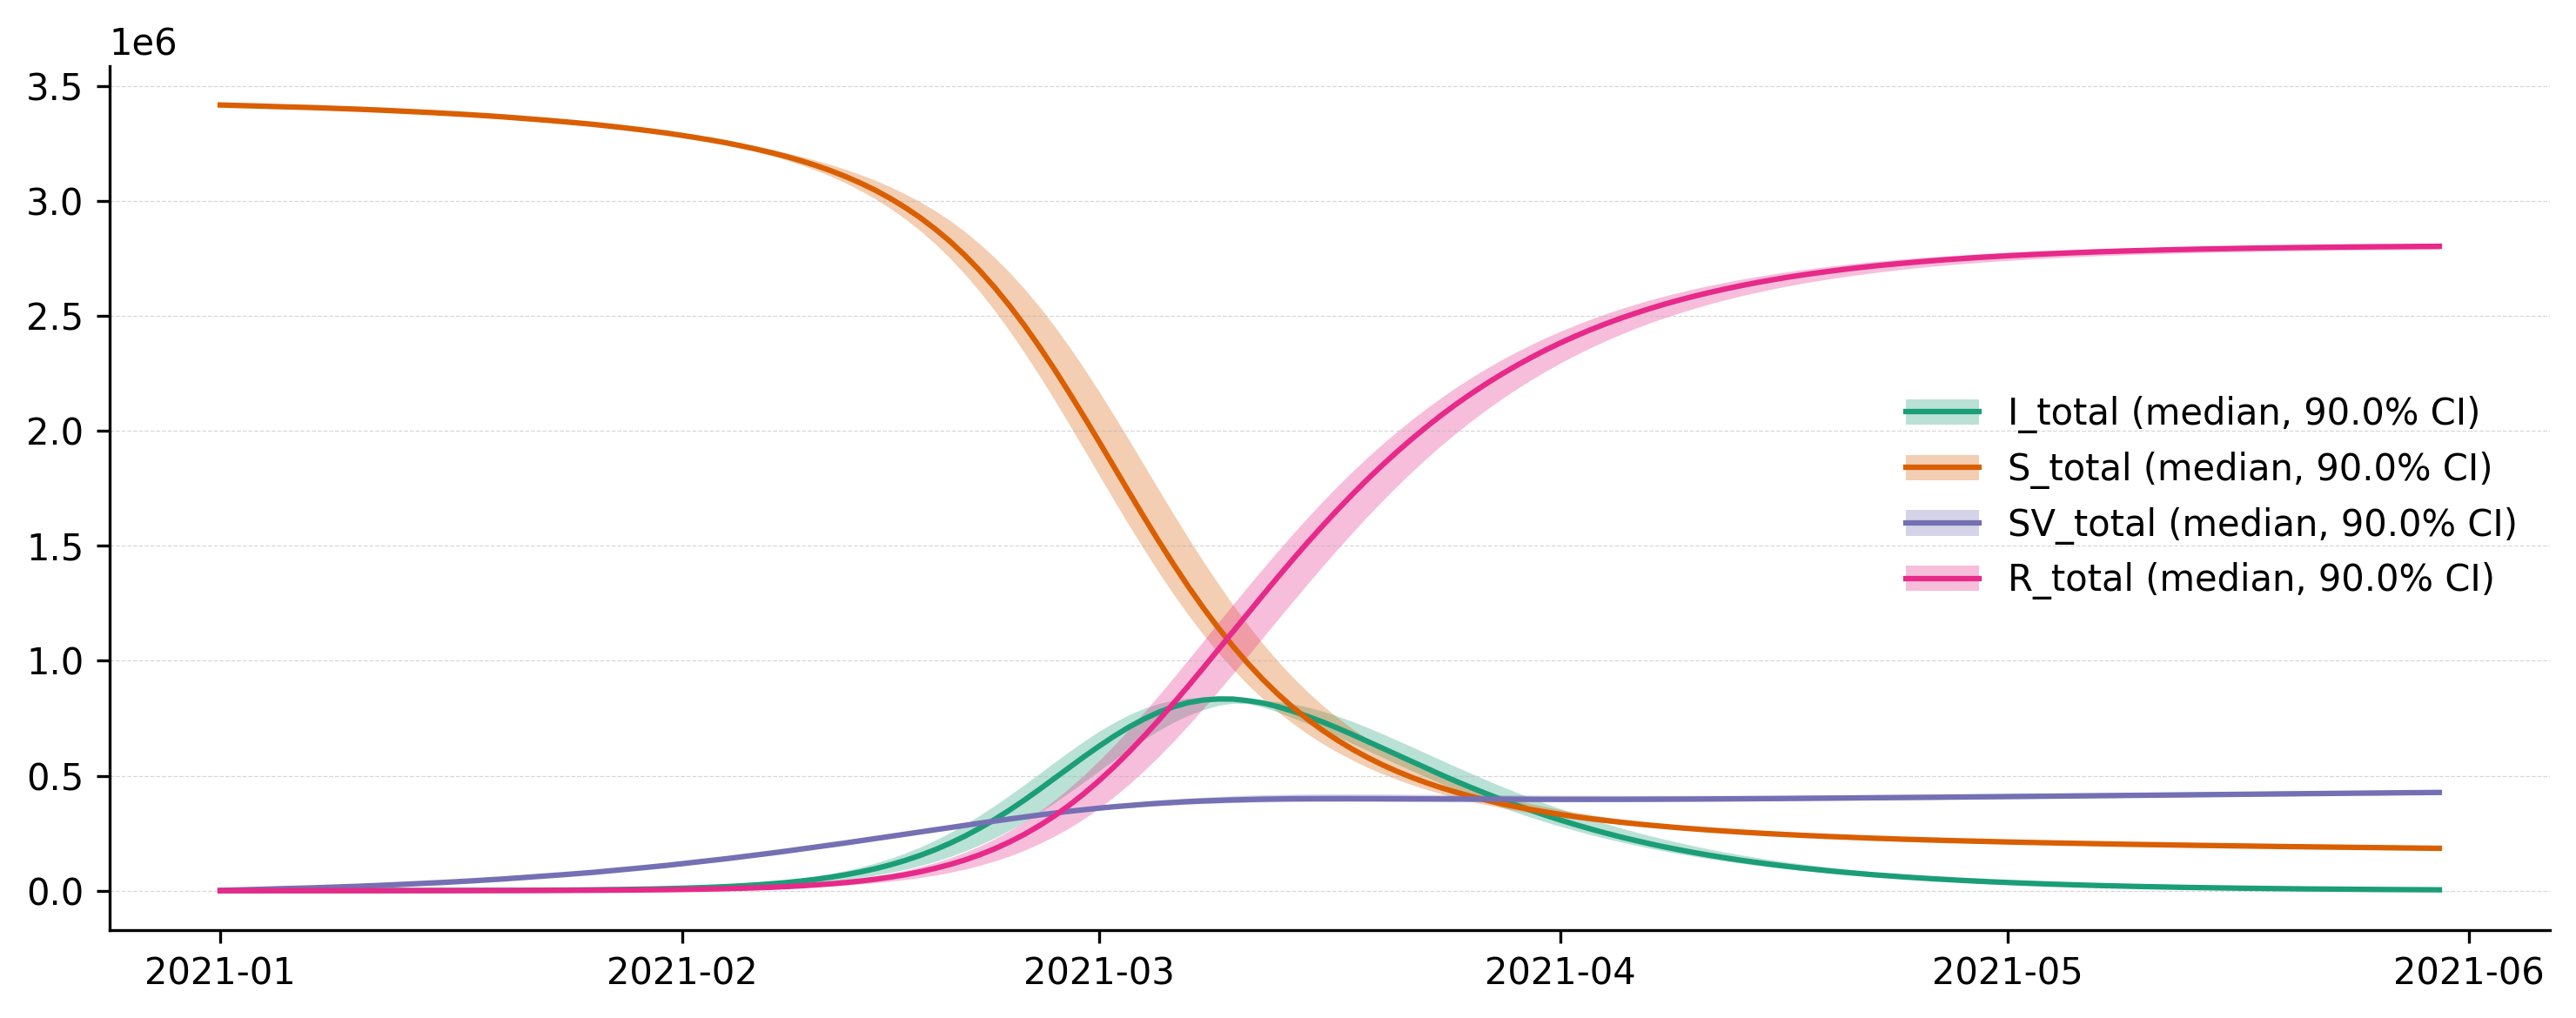

In [6]:
from epydemix.visualization import plot_quantiles

df_quantiles_comps = results.get_quantiles_compartments()
ax = plot_quantiles(df_quantiles_comps, columns=["I_total", "S_total", "SV_total", "R_total"], legend_loc="center right")

And the individual $S_V$ in each age group:

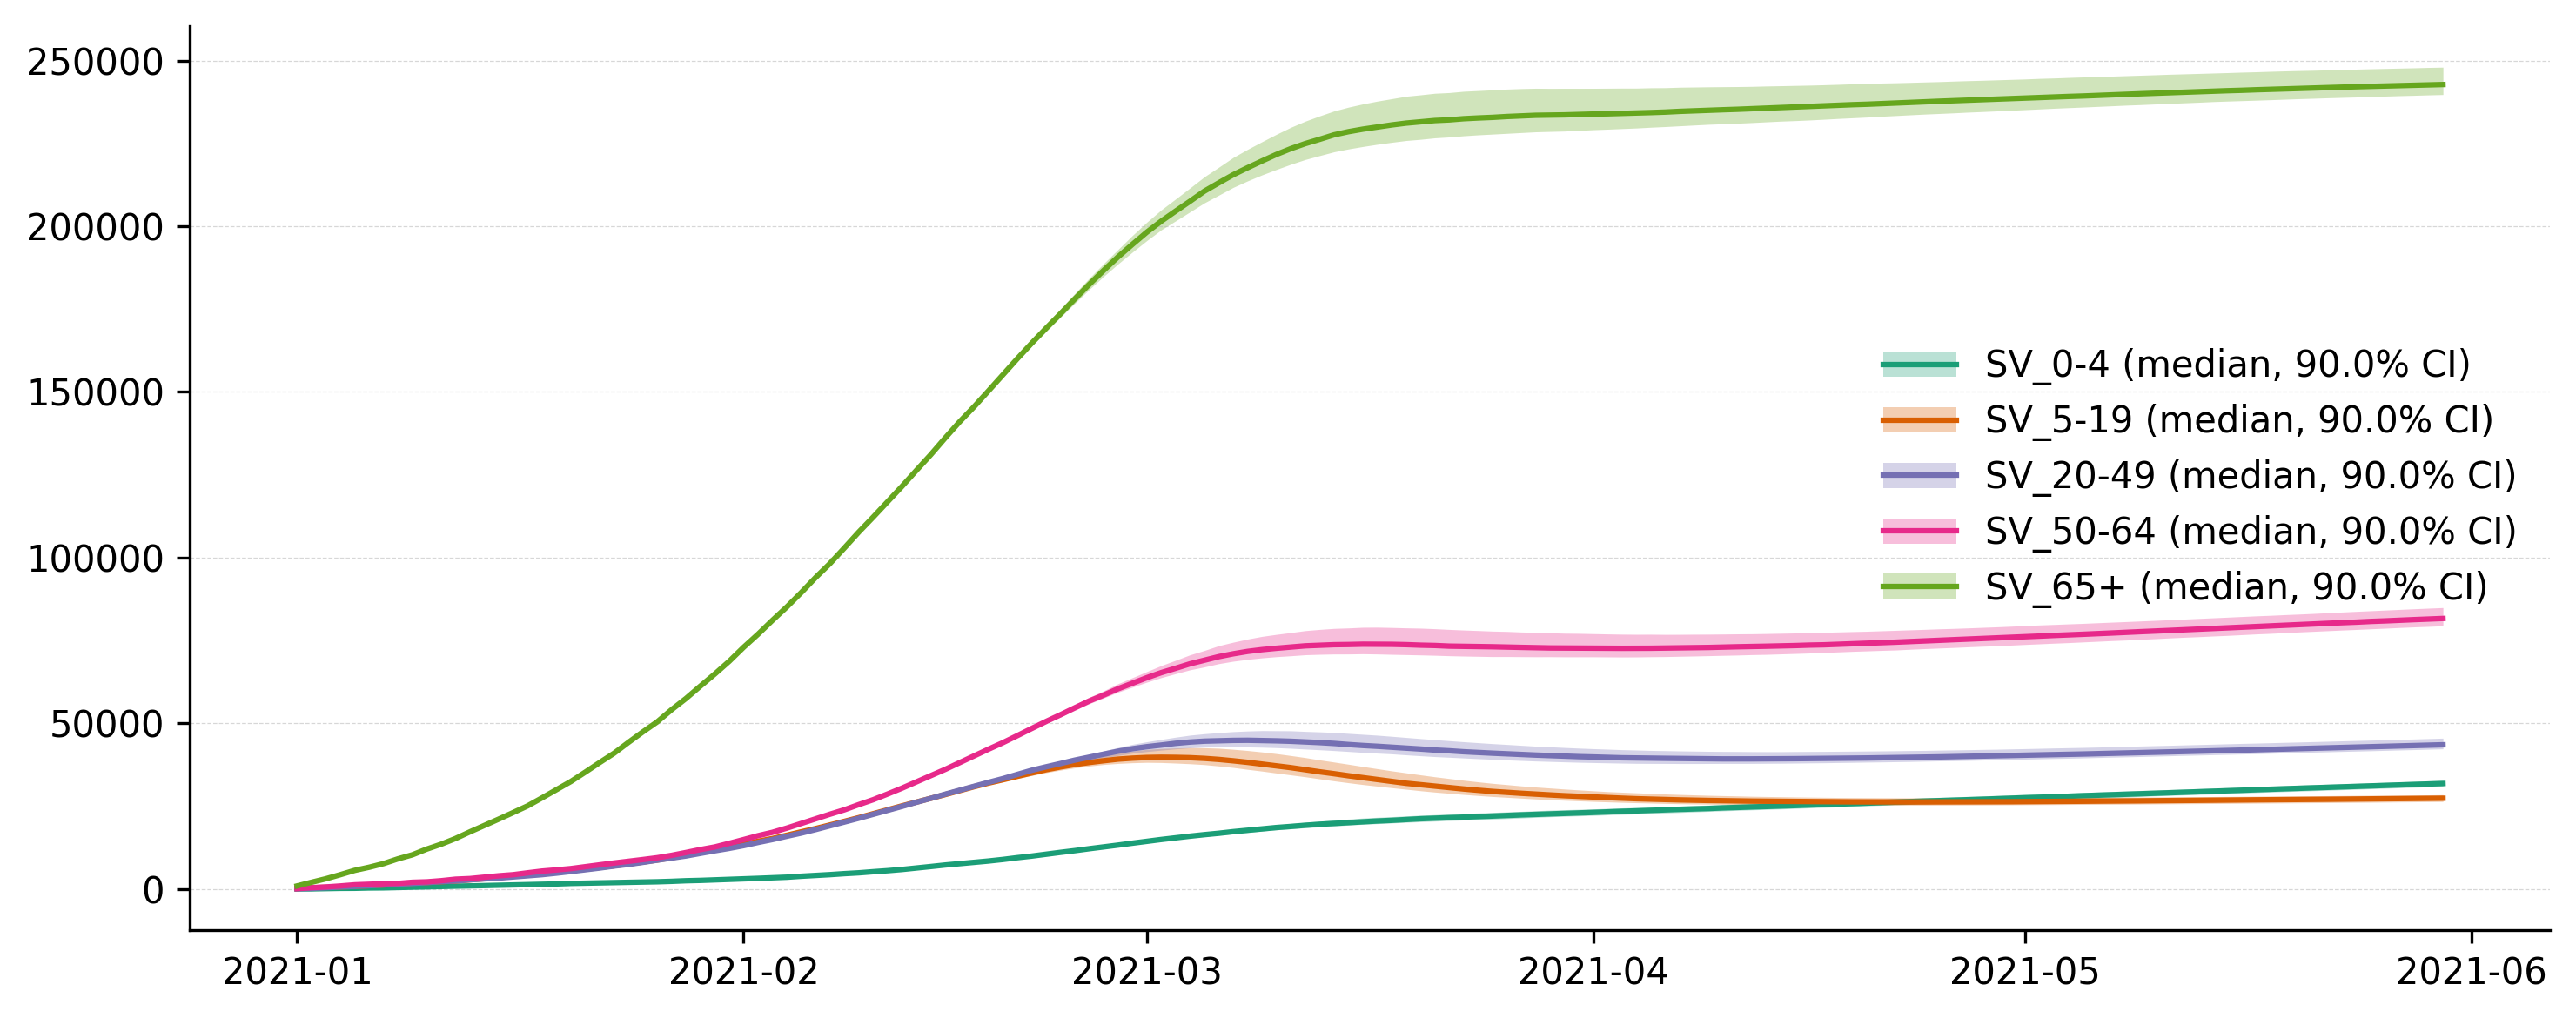

In [7]:
ax = plot_quantiles(df_quantiles_comps, columns=["SV_0-4", "SV_5-19", "SV_20-49", "SV_50-64", "SV_65+"], legend_loc="center right")

As a final check, we can compare the number of individuals effectively vaccinated in the simulation (i.e., the individuals transitioning $S \rightarrow S_V$ each day), the number of doses in the initial file, and the number of effective doses which accounts for the growing fraction of $R$ individuals. 

We can see how, at the beginning, the total doses, the effective doses, and the number of $S \rightarrow S_V$ transitions overlaps. When instead $R$ grows, the number of $S \rightarrow S_V$ transitions diverge from the total daily doses and follows the evolution of computed number of effective doses, as expected.

In [ ]:
import matplotlib.pyplot as plt

# Get Transitions and Compartments over time
df_quantiles_trans = results.get_quantiles_transitions()
df_comp = results.get_quantiles_compartments()
df_median = df_comp.loc[df_comp["quantile"] == 0.5]

# Plot total doses, effective doses, and S -> S_V transitions
fig, axes = plt.subplots(5,1, figsize=(12, 10), dpi=300)

for i, age_group in enumerate(['0-4', '5-19', '20-49', '50-64', '65+']): 

    # compute effective doses (total doses * fraction of S, median)
    df_doses[f"effective_doses_{age_group}"] = df_doses[age_group].values * df_median[f"S_{age_group}"].values / (df_median[f"S_{age_group}"].values + df_median[f"R_{age_group}"].values)
    
    # plot
    ax = plot_quantiles(df_quantiles_trans, columns=[f"S_to_SV_{age_group}"], legend_loc="center right", ax=axes[i])
    ax.plot(df_doses.index, df_doses[age_group], linestyle="dotted", alpha=0.5, label="Total Doses")
    ax.plot(df_doses.index, df_doses[f"effective_doses_{age_group}"], linestyle="--", alpha=0.5, color="r", label="Effective Doses")
    ax.set_title("Age group: " + age_group, x=0, ha="left")
    ax.legend()